# Geolocation project

## Bonus: Big Data and Cloud Execution

#### Distributed Data and Data Engineering Spring 2020

#### By: Sam Watson

I found another, even bigger dataset, and will apply the same k-means approach to it.

#### About the Data:

The data was retrieved from the US Department of Transportation. The website holds all airline data reported to the U.S. Department of Transportation (DOT) from the top 12 U.S air carriers. The data was borrowed from my previous semster's assigment in Deep Learning. I am using all of 2018 flights that experienced a delay, and will cluster the data around the total distance and total delay time. The total number of records here is about 1.4 million.

Link to dataset: https://transtats.bts.gov/ONTIME/


In [23]:
#importing modules!
import pyspark
from pyspark.sql.functions import *

#### Loading the Data:

In [26]:
data=spark.read.format('csv').options(header='true').load("s3a://geocluster/flightdelay.csv")
data.show(10)

+---+--------+-------------+-------------+---------+--------------+-------------------+-----+
|_c0|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|DELAY|
+---+--------+-------------+-------------+---------+--------------+-------------------+-----+
| 11|   316.0|        121.0|          0.0|      8.0|           0.0|                0.0|129.0|
| 14|   763.0|          0.0|         11.0|      0.0|           0.0|               62.0| 73.0|
| 15|  2218.0|         54.0|          0.0|      1.0|           0.0|                0.0| 55.0|
| 16|  2500.0|          7.0|          0.0|      0.0|           0.0|               18.0| 25.0|
| 17|  1068.0|         29.0|          0.0|      0.0|           0.0|                0.0| 29.0|
| 27|  1167.0|         27.0|          0.0|      0.0|           0.0|                0.0| 27.0|
| 56|   403.0|          0.0|         26.0|      0.0|           0.0|                0.0| 26.0|
| 61|   177.0|          0.0|         18.0|      0.0|        

In [29]:
data.count()

1352710

In [31]:
data=data.withColumn('DISTANCE',data['DISTANCE'].cast("float"))
data=data.withColumn('DELAY',data['DELAY'].cast("float"))

In [33]:
data=data.select("DISTANCE","DELAY")
data.show()

+--------+-----+
|DISTANCE|DELAY|
+--------+-----+
|   316.0|129.0|
|   763.0| 73.0|
|  2218.0| 55.0|
|  2500.0| 25.0|
|  1068.0| 29.0|
|  1167.0| 27.0|
|   403.0| 26.0|
|   177.0| 75.0|
|   266.0|124.0|
|   109.0|291.0|
|   447.0| 28.0|
|   723.0| 64.0|
|  2218.0| 16.0|
|   862.0| 28.0|
|  1182.0| 72.0|
|   191.0| 30.0|
|  1346.0|117.0|
|  1303.0|269.0|
|  1182.0| 31.0|
|   200.0|100.0|
+--------+-----+
only showing top 20 rows



#### Making my Kmeans Functions!

In [34]:
#creating a function that will calculate kmeans for a given dataset with columns "_c0", "_c1". 
#the function takes how many clusters, and why distance measure (euclidean/cosine) as input parameters

def mykmeans(data,val,dist):
    #importing libraries
    import pyspark
    from pyspark.sql.functions import *
    from pyspark.ml.feature import VectorAssembler
    from pyspark.ml.clustering import KMeans
    #parsing the data as input pairs
    vecAssembler = VectorAssembler(inputCols=["DISTANCE","DELAY"],outputCol="features")
    new = vecAssembler.transform(data).cache()
    kmeans = KMeans(k=int(val),seed=1,distanceMeasure=str(dist))
    model=kmeans.fit(new.select("features"))
    transformed=model.transform(new)
    #getting centers:
    centers=model.clusterCenters()

    return transformed,centers

<ipython-input-34-12d9a13f0fd3>:4: SyntaxWarning: import * only allowed at module level
  def mykmeans(data,val,dist):


In [37]:
#creating a function that takes the output of mykmeans function, and plots it

def myplotter(data,val,dist):
    #import libraries 
    import matplotlib.pyplot as plt
    import numpy as np
    #make title
    title='Flight Distance/Flight Delay with k= '+str(val)+' and '+str(dist)+' distance'
    #getting clustered data
    outputs,centers=mykmeans(data,val,dist)

    plt.figure(figsize=(6,6))
    #plot each cluster
    for i in range(val):
        dftoplot=outputs.filter(outputs.prediction==i)
        lats=dftoplot.select('DISTANCE').collect()
        lats = np.asarray(lats)
        lats=lats.T[0]
        longs=dftoplot.select('DELAY').collect()
        longs = np.asarray(longs)
        longs=longs.T[0]
        plt.scatter(lats,longs)
    #plotting centers
    for i in range(len(centers)):
        plt.scatter(centers[i][0],centers[i][1],c='black',s=30,alpha=.7)
    plt.title(title)
    plt.xlabel('Distance')
    plt.ylabel('Delay')
    return plt.show

### Using the Kmeans Function

Once with threading, and once without!

In [41]:
%%time

from multiprocessing.pool import ThreadPool

# allow up to 3 concurrent threads
pool = ThreadPool(3)
# each dataset
parameters = [data]

pool.map(lambda dataset: mykmeans(dataset,4,'euclidean'), parameters)

CPU times: user 31.4 ms, sys: 13.1 ms, total: 44.5 ms
Wall time: 12.5 s


CPU times: user 44.2 s, sys: 2.48 s, total: 46.6 s
Wall time: 57.2 s


<function matplotlib.pyplot.show>

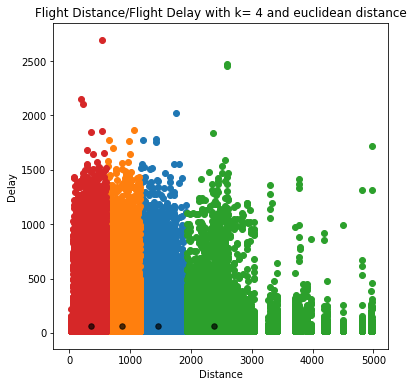

In [42]:
%%time

myplotter(data,4,'euclidean')